Actividad semanal 7 : K-Means

Alumno: Enrique Ricardo García Hernández - A01315428

Profesor: María de la Paz Rico Fernández

Fecha: Nov 11 2022

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logística acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 7.5 MB/s 
     |████████████████████████████████| 1.0 MB 47.9 MB/s 
     |████████████████████████████████| 1.7 MB 42.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 54.2 MB/s 
     |████████████████████████████████| 6.3 MB 39.6 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=ff8f7b2235250c7f577f09f33a625bac3df37038def05493fcd5bf72b91e34b0
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=1fd0cb6cc6f8de59b58b607a7dab9e9b78b242eb50000f06ca716dbdeb790f39
  Stored in directory: /root/.

In [105]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [184]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [185]:
df.head()

,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [109]:
latlong=df[["latitude","longitude"]]

In [187]:
latlong.head(5)

,latitude,longitude
0,33.224225,-86.804174
1,33.334550,-86.989778
2,30.602875,-87.895932
3,34.560148,-86.971559
4,31.266061,-85.446422


¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

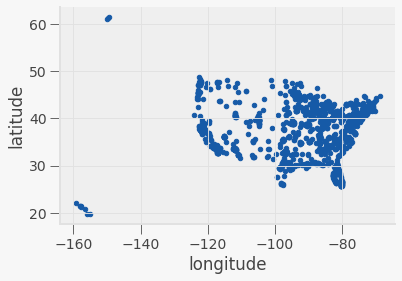

In [188]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [189]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [190]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [191]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [192]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [193]:
#mapa
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [194]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

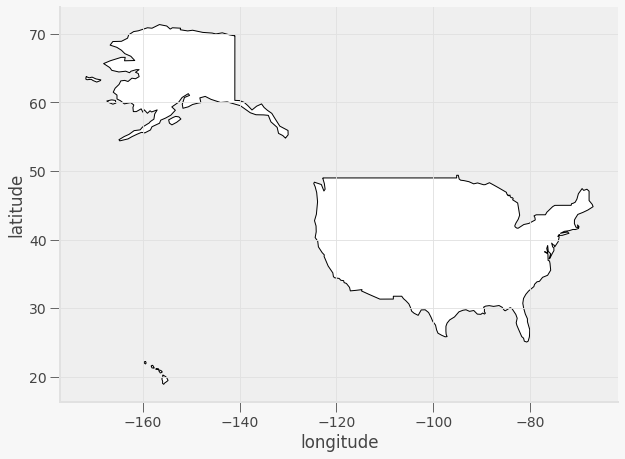

In [195]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

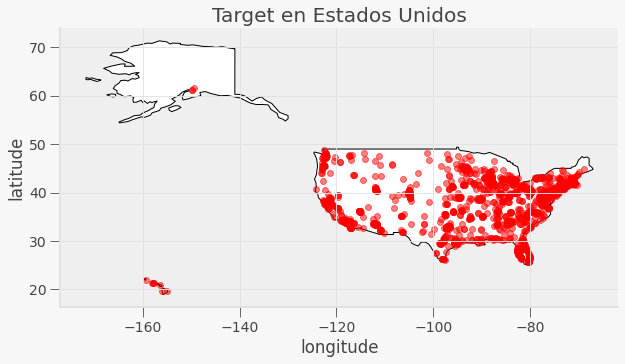

In [196]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

In [197]:
latlong.head(5)

,latitude,longitude
0,33.224225,-86.804174
1,33.334550,-86.989778
2,30.602875,-87.895932
3,34.560148,-86.971559
4,31.266061,-85.446422


In [198]:
#tu codigo aquí
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale #Se decide NO normalizar los casos, dados que están en unidades comparables

# Normalización de las variables
# ==============================================================================
#datos_scaled = scale(X=latlong, axis=0, with_mean=True, with_std=True) 
#datos_scaled = pd.DataFrame(datos_scaled, columns=latlong.columns, index=latlong.index)
#datos_scaled.head(4) #Vemos las 4 primeras observaciones una vez que se normalizaron las coordenadas

In [199]:
latlong.shape

(1839, 2)

In [201]:
# Cálculo de distancias
# ==============================================================================
print('Distancia euclídea')
distancias = pairwise_distances(
                X      = latlong,
                metric ='euclidean'
             )

# Se descarta la diagonal superior de la matriz
distancias[np.triu_indices(n=distancias.shape[0])] = np.nan

distancias = pd.DataFrame(
                distancias,
                columns=latlong.index,
                index = latlong.index
            )

distancias.iloc[:4,:4]

Distancia euclídea


,0,1,2,3
0,NaN,NaN,NaN,NaN
1,0.215918,NaN,NaN,NaN
2,2.839615,2.878049,NaN,NaN
3,1.346368,1.225733,4.0638,NaN


In [125]:
# Modelo inicial con 4 cluster
# ==============================================================================
modelo_kmeans = KMeans(n_clusters=4, n_init=25, random_state=123)
modelo_kmeans.fit(latlong)

KMeans(n_clusters=4, n_init=25, random_state=123)

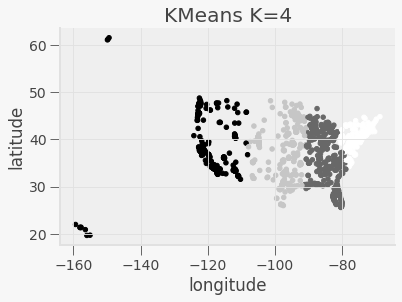

In [134]:
y_predict = KMeans(n_clusters=4, n_init=25, random_state=123).fit_predict(X=latlong)
latlong.plot.scatter( "longitude","latitude",c=y_predict,marker='o')
plt.title('KMeans K=4');

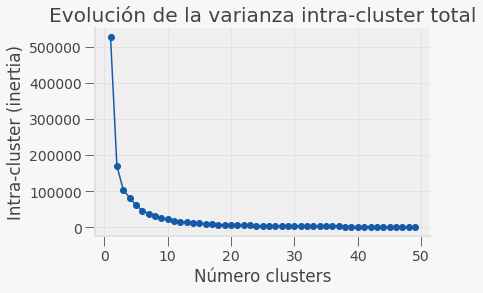

In [135]:
# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 50)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 25, 
                        random_state = 123
                    )
    modelo_kmeans.fit(latlong)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

In [202]:
inertias

[527995.4430694166,
 171146.62599564373,
 104757.83160206435,
 82987.9377244747,
 62084.98122993491,
 46975.34806670378,
 38599.669972231466,
 31578.054907185822,
 25445.045647612762,
 22453.91607204736,
 19351.977552859535,
 16474.30890878512,
 14254.748387838736,
 12608.79815729292,
 11311.084613648378,
 10017.92778055932,
 8898.992173798972,
 8028.972267728299,
 7462.1636637633,
 6847.946048532134,
 6386.307989919049,
 5843.751330089213,
 5585.802266580236,
 5111.0833932190835,
 4770.749017839296,
 4537.221539969777,
 4354.906643343267,
 4131.734049550725,
 3994.299760271623,
 3764.100065888033,
 3610.2513363163134,
 3387.916407547802,
 3295.424309831161,
 3154.670386581094,
 3025.0137359360383,
 2882.377724121672,
 2798.3902829563885,
 2654.5190037493758,
 2591.993318755567,
 2497.356838126907,
 2419.7665298851853,
 2320.7853276671335,
 2200.735732245961,
 2160.1280188196283,
 2086.9356320272827,
 2049.5194006544884,
 1971.4182321362723,
 1965.0981877159404,
 1875.9384426826703]

In [203]:
#Con el método del codo, podríamos proponer un número óptimo alrededor de 11 ó 12 cluster

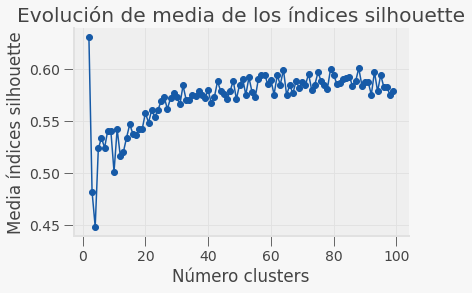

In [204]:
from sklearn.metrics import silhouette_score
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 100)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    cluster_labels = modelo_kmeans.fit_predict(latlong)
    silhouette_avg = silhouette_score(latlong, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [ ]:
#Con este método, el número óptimo de almacenes ronda ~ 12 a 15, las aportaciones a partir de 15 clusters empiezan a ser marginales

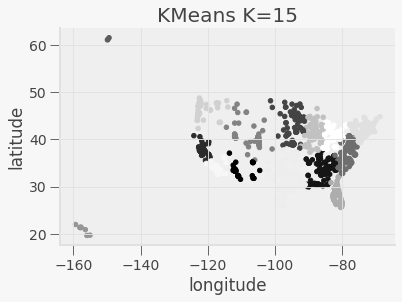

In [205]:
y_predict = KMeans(n_clusters=15, n_init=25, random_state=123).fit_predict(X=latlong)
latlong.plot.scatter( "longitude","latitude",c=y_predict,marker='o')
plt.title('KMeans K=15');

In [206]:
latlong.info

<bound method DataFrame.info of        latitude   longitude
0     33.224225  -86.804174
1     33.334550  -86.989778
2     30.602875  -87.895932
3     34.560148  -86.971559
4     31.266061  -85.446422
...         ...         ...
1834  43.034293  -88.176840
1835  42.989604  -88.259806
1836  42.846799 -106.264166
1837  41.162019 -104.800048
1838  43.469617 -110.789456

[1839 rows x 2 columns]>

In [207]:
y_predict=y_predict.T
cluster=pd.DataFrame(y_predict)
cluster.columns = ['gpo_cluster']
cluster.columns
cluster

,gpo_cluster
0,13
1,13
2,13
3,13
4,13
...,...
1834,5
1835,5
1836,8
1837,8


In [208]:
salida=pd.concat([latlong,cluster], axis=1)
salida.head(5)

,latitude,longitude,gpo_cluster
0,33.224225,-86.804174,13
1,33.334550,-86.989778,13
2,30.602875,-87.895932,13
3,34.560148,-86.971559,13
4,31.266061,-85.446422,13


In [209]:
salida=pd.merge(salida, gdf, on=['latitude','longitude'],how='outer')
salida.head(5)

,latitude,longitude,gpo_cluster,name,address,phone,website,Coordinates
0,33.224225,-86.804174,13,Alabaster,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,33.334550,-86.989778,13,Bessemer,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,30.602875,-87.895932,13,Daphne,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,34.560148,-86.971559,13,Decatur,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,31.266061,-85.446422,13,Dothan,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [228]:
#Contador de tiendas por cluster
pivot=salida.groupby(['gpo_cluster']).count()
pivot['latitude'] #Número de tiendas por cluster

gpo_cluster
0     159
1     140
2     213
3     283
4      69
5     197
6     120
7       8
8      74
9     190
10      3
11    140
12     80
13    136
14     57
Name: latitude, dtype: int64

De acuerdo con la información obtenida, en EEUU hay 1,839 tiendas Target, buscando poner los almacenes en puntos estratégicos que acorten las distancias para el reabastecimiento de dichas tiendas, usando la metodología de K-Means (distancia euclidiana), podemos pensar que con ~15 centros de distribución se puede dar atención.

Dichos centros estarían en los centroides de cada uno de los 15 grupos.

Los clusters 3 y 2, serían los que mayor número de tiendas estarían surtiendo, con 283 y 213 tiendas, respectivamente.